In [1]:
import pandas as pd
# Transaktions-Datei einlesen
train = pd.read_parquet("transactions_train_3.parquet")

In [2]:
# Nur Verlustfälle betrachten
fraud = train[train.label == "FRAUD"]

In [3]:
# Produktdatei einlesen
products = pd.read_csv("products.csv")

In [4]:
Transaktionslines-Datei einlesen
lines = pd.read_parquet("transaction_lines_train_3.parquet")

In [5]:
# 1. JOIN transactions + transaction_lines
merged = lines.merge(fraud, left_on="transaction_id", right_on="id", suffixes=('_line', '_tx'))

In [6]:
merged.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53564 entries, 0 to 53563
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id_line                 53564 non-null  int64         
 1   transaction_id          53564 non-null  object        
 2   product_id              53547 non-null  object        
 3   timestamp               53564 non-null  datetime64[ns]
 4   pieces_or_weight        53564 non-null  float64       
 5   sales_price             53564 non-null  float64       
 6   was_voided              53564 non-null  bool          
 7   camera_product_similar  53399 non-null  object        
 8   camera_certainty        53399 non-null  float64       
 9   id_tx                   53564 non-null  object        
 10  store_id                53564 non-null  object        
 11  cash_desk               53564 non-null  int64         
 12  transaction_start       53564 non-null  dateti

In [7]:
# 2. JOIN mit products
merged = merged.merge(products, how="left", left_on="product_id", right_on="id")


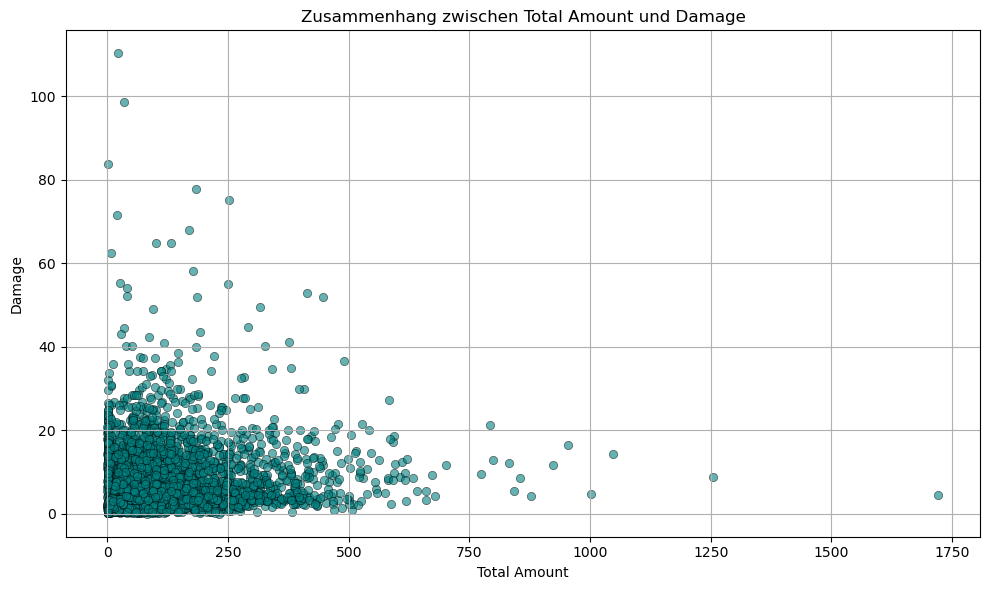

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=fraud, x='total_amount', y='damage', alpha=0.6, color='teal', edgecolor='black')

plt.title('Zusammenhang zwischen Total Amount und Damage')
plt.xlabel('Total Amount')
plt.ylabel('Damage')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
fraud.damage.nlargest(6)

133918     110.32
648697      98.60
1437651     83.90
116764      77.87
847478      75.18
1361260     71.52
Name: damage, dtype: float64

In [11]:
# Berechnung der rechnerisch richtigen sales_prices
merged["sales_price_calc"] = merged["pieces_or_weight"] * merged["price"]
# Summe der Artikelpreise je Transaktion berechnen
summe_calc = merged.groupby("transaction_id")["sales_price_calc"].sum()

# In den ursprünglichen DataFrame einfügen (Zeilenweise per Mapping)
merged["sales_sum_per_transaction"] = merged["transaction_id"].map(summe_calc)

# Differenz zwischen berechneter Summe und originalem total_amount
merged["betrag_diff"] = merged["sales_sum_per_transaction"] - merged["total_amount"]



In [22]:
# Spalte Differenz zwischen Betra Kassenbon und Preise aller gekauften Artikel
merged["difference"] = merged.total_amount - merged.sales_sum_per_transaction

In [16]:
# alle Differenzen, die der Schadensumme entsprechen
differenzen =merged[(merged.difference + merged.damage).abs()<0.01][["transaction_id","total_amount","sales_sum_per_transaction","damage","difference"]]

In [23]:
# alle Transaktionen, die sich durch Rechenfehler erklären lassen
rechenfehler =differenzen.groupby("transaction_id").first()

In [24]:
rechenfehler.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1675 entries, 001ee2b1-a10c-4577-9f29-74a510df2f98 to ff77bb77-8036-4a13-ae21-c2f6b92d2bb0
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   total_amount               1675 non-null   float64
 1   sales_sum_per_transaction  1675 non-null   float64
 2   damage                     1675 non-null   float64
 3   difference                 1675 non-null   float64
dtypes: float64(4)
memory usage: 65.4+ KB


In [29]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4656 entries, 345 to 1481774
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 4656 non-null   object        
 1   store_id           4656 non-null   object        
 2   cash_desk          4656 non-null   int64         
 3   transaction_start  4656 non-null   datetime64[ns]
 4   transaction_end    4656 non-null   datetime64[ns]
 5   total_amount       4656 non-null   float64       
 6   n_lines            4656 non-null   int64         
 7   payment_medium     4656 non-null   object        
 8   customer_feedback  349 non-null    float64       
 9   damage             4656 non-null   float64       
 10  label              4656 non-null   object        
dtypes: datetime64[ns](2), float64(3), int64(2), object(4)
memory usage: 565.5+ KB


In [25]:
rechenfehler.damage.sum()

10715.55

In [26]:
fraud.damage.sum()

35172.119999999995

In [18]:
# alle Transaktionen mit Fraud und Rechenfehler
lines_filtered = lines[lines['transaction_id'].isin(differenzen['transaction_id'])]
lines_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17626 entries, 13791 to 15788668
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      17626 non-null  int64         
 1   transaction_id          17626 non-null  object        
 2   product_id              17626 non-null  object        
 3   timestamp               17626 non-null  datetime64[ns]
 4   pieces_or_weight        17626 non-null  float64       
 5   sales_price             17626 non-null  float64       
 6   was_voided              17626 non-null  bool          
 7   camera_product_similar  17580 non-null  object        
 8   camera_certainty        17580 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 1.2+ MB
